# Starbucks Customer Segmentation

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to its users through various media (website, email, social, and mobile app). An offer can be an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 10 days. 

We are given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as records for when a user actually views and/or complete the offer. Moreoever, there are also records for customers that make purchases through the app without having received an offer or seen an offer.

## Machine Learning checklist:

 1. Define a problem statement
 2. Retrieve the dataset 
 3. Explore the data to gain insightful information
 4. Feature processing
 5. Employ different Unsupervised ML models
     * MeanShift
     * Affinity Propagation
     * Mini-Batch K-Means
     * K-Means
 6. Pick and refine the chosen model 
     * Silhouette Score
      - The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters. The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
     * Inertia (SSE)
      - Measure how internally coherent clusters. The smaller its value, the better.
     * Elbow Method
 7. Conclusion 

 
## Define a problem statement

**`The aim is to find the most suitable (unsupervised) algorithm to gain understanding of customer demographics and their purchasing behaviors.`**


## Retrieve the dataset

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**

 * id (string) - offer id
 * offer_type (string) - type of offer ie BOGO, discount, informational
 * difficulty (int) - minimum required spend to complete an offer
 * reward (int) - reward given for completing an offer
 * duration (int) -
 * channels (list of strings)

**profile.json**

 * age (int) - age of the customer
 * became_member_on (int) - date when customer created an app account
 * gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
 * id (str) - customer id
 * income (float) - customer's income

**transcript.json**

 * event (str) - record description (ie transaction, offer received, offer viewed, etc.)
 * person (str) - customer id
 * time (int) - time in hours. The data begins at time t=0
 * value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [22]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## Data Exploration

### Portfolio Dataset

In [3]:
# let's take a look at portfolio
portfolio.head(5)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


* Apply `get_dummies` to the channels column.
* Add a new column that combines the `offer_type`, `difficulty`, `reward`, and `duration`. For example, `bogo_20_5_10` means offer type of BOGO with difficulty of 20 dollars, reward of 5 dollars, and duration for 10 days.

In [23]:
# write functions for cleaning portfolio
# function for adding a new column
def add_type(portfolio_df):
    portfolio_df['type'] = portfolio_df.offer_type.astype(str) + '_' + portfolio_df.difficulty.astype(str) + '_' + portfolio_df.reward.astype(str) + '_' + portfolio_df.duration.astype(str)
    return portfolio_df

# function for get dummies the channels col
def get_dummies_channels(portfolio_df):
    dummies = pd.get_dummies(portfolio_df.channels.apply(pd.Series).stack()).sum(level=0)
    portfolio_df = pd.concat([portfolio_df, dummies], axis=1)
    portfolio_df = portfolio_df.drop('channels', axis=1)
    return portfolio_df

# combine the above functions
def preprocessed_portfolio(portfolio_df):
    portfolio_df = add_type(portfolio_df)
    portfolio_df = get_dummies_channels(portfolio_df)
    return portfolio_df

In [24]:
new_portfolio = preprocessed_portfolio(portfolio)
# dummies_2 = pd.get_dummies(new_portfolio.offer_type)
# new_portfolio = pd.concat([new_portfolio, dummies_2], axis=1)
new_portfolio.head()

,difficulty,duration,id,offer_type,reward,type,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,bogo_10_10_7,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,bogo_10_10_5,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,informational_0_0_4,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,bogo_5_5_7,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,discount_20_5_10,1,0,0,1


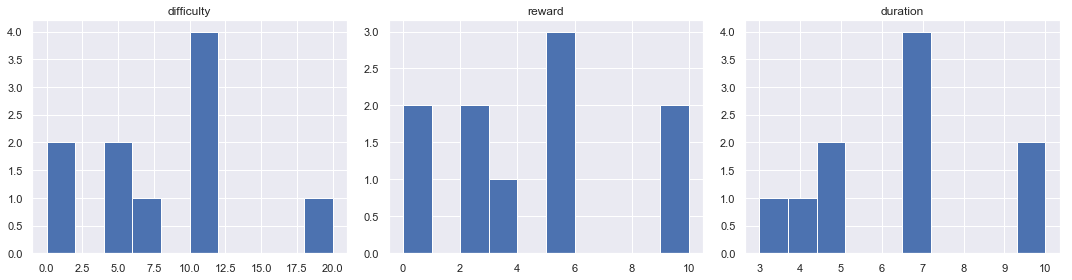

In [95]:
cols = ['difficulty', 'reward', 'duration']
plt.figure(figsize=(15,4))

for i in range(len(cols)):
    plt.subplot(1,3, i+1)
    plt.hist(x=cols[i], data=new_portfolio)
    plt.title(cols[i])
plt.tight_layout()
plt.show()

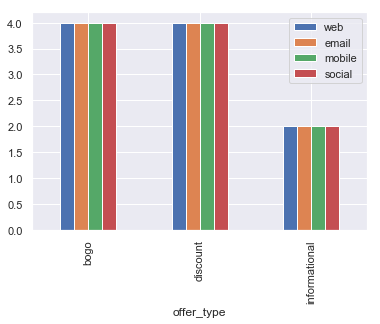

In [96]:
channels = ['web', 'email', 'mobile', 'social']
new_portfolio.groupby('offer_type').count()[channels].plot(kind='bar')
plt.show()

* *bogo* and *discount* are the most common types of offer. 
* The offers are sent out through different channels equally

### Profile Dataset

In [9]:
profile.head(3)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


In [10]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
profile.describe(include='all')

,age,became_member_on,gender,id,income
count,17000.000000,1.700000e+04,14825,17000,14825.000000
unique,NaN,NaN,3,17000,NaN
top,NaN,NaN,M,976931110347490ba94ef6e8db5bd5f4,NaN
freq,NaN,NaN,8484,1,NaN
mean,62.531412,2.016703e+07,NaN,NaN,65404.991568
std,26.738580,1.167750e+04,NaN,NaN,21598.299410
min,18.000000,2.013073e+07,NaN,NaN,30000.000000
25%,45.000000,2.016053e+07,NaN,NaN,49000.000000
50%,58.000000,2.017080e+07,NaN,NaN,64000.000000
75%,73.000000,2.017123e+07,NaN,NaN,80000.000000


In [5]:
profile.groupby('gender').describe()['income']

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,71306.412139,22338.353773,30000.0,54000.0,71000.0,88000.0,120000.0
M,8484.0,61194.601603,20069.517615,30000.0,45000.0,59000.0,73000.0,120000.0
O,212.0,63287.735849,18938.594726,30000.0,51000.0,62000.0,79250.0,100000.0


C:\Users\vungu\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vungu\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


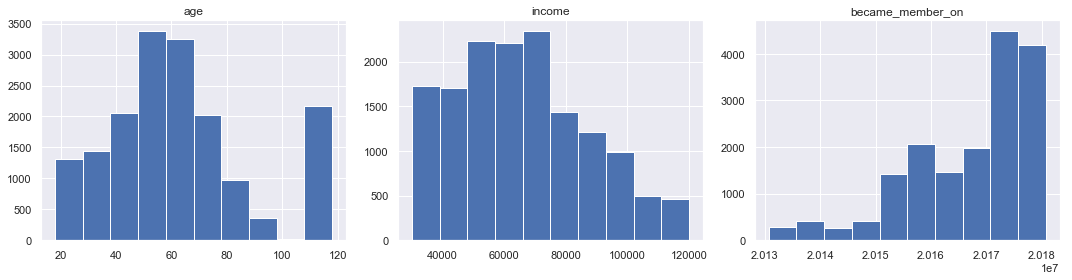

In [14]:
# distribution of numeric columns
cols = ['age', 'income', 'became_member_on']
plt.figure(figsize=(15,4))

for i in range(len(cols)):
    plt.subplot(1,3, i+1)
    plt.hist(x=cols[i], data=profile)
    plt.title(cols[i])
plt.tight_layout()
plt.show()

* Have to look more into the older-than-100 age group because it is highly suspicious.
* There a few customers that make more than 100k.
* Majority of customers becomes a member between 2017 - 2018.

In [26]:
profile[profile.age > 100]['age'].value_counts()

118    2175
101       5
Name: age, dtype: int64

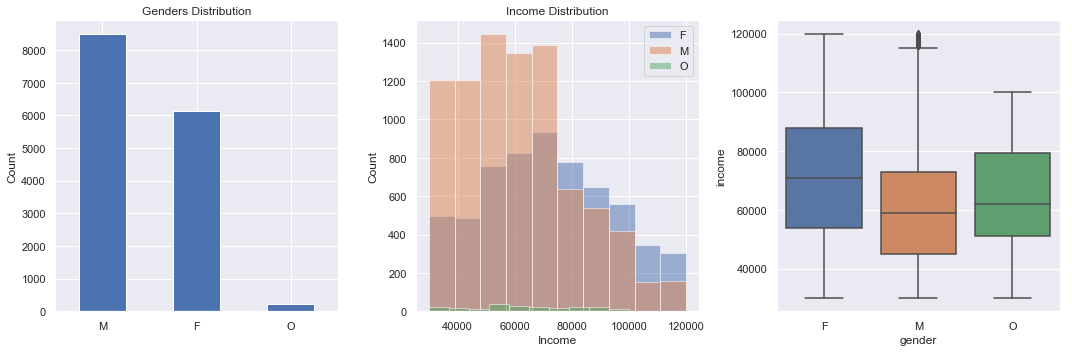

In [16]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

# plot gender distribution 
profile.gender.value_counts().plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_title('Genders Distribution')
ax1.set_ylabel('Count')

# plot income distribution 
ax2.hist(profile[profile.gender=='F']['income'],alpha=0.5,label='F')
ax2.hist(profile[profile.gender=='M']['income'],alpha=0.5,label='M')
ax2.hist(profile[profile.gender=='O']['income'],alpha=0.5,label='O')
ax2.set_xlabel('Income')
ax2.set_ylabel('Count')
ax2.set_title('Income Distribution')
ax2.legend()

# boxplot of income
sns.boxplot('gender','income',data=profile,ax=ax3,order=['F','M','O'])

plt.tight_layout()
plt.show()

### Overalls:

* There are 17000 profiles and 2175 of them have missing values in `gender` and `income`
* The mean age is 62.5 with standard deviation of 26.7
* The mean income is 65,405 dollars with standard deviation of 21,598 dollars
* There are 2180 profiles (12.8%) with age of 100 years or more. 
* Most of customers are males (50%), followed by females (36%) and unknown (14%)
* The average income of female customers (71,306 dollars) is higher than that of male customers (61,194 dollars) and other gender customers (63,287 dollars)

**Parsing Dates**

In [27]:
def parse_dates(profile_df):
    profile_df = profile_df.copy()
    profile_df['became_member_on'] = profile_df.became_member_on.apply(lambda x: str(x))
    profile_df['became_member_on'] = pd.to_datetime(profile_df.became_member_on)
    return profile_df

new_profile = parse_dates(profile)
new_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB


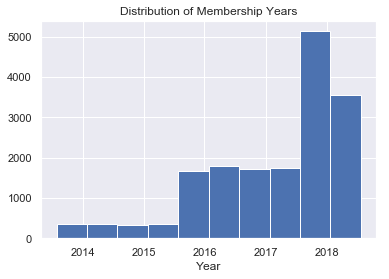

In [28]:
# plot membership time
new_profile.became_member_on.hist()
plt.xlabel('Year')
plt.title('Distribution of Membership Years')
plt.show()

## Transcript Dataset

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.tail()

,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [21]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [22]:
transcript.describe(include='all')

,event,person,time,value
count,306534,306534,306534.000000,306534
unique,4,17000,NaN,5121
top,transaction,94de646f7b6041228ca7dec82adb97d2,NaN,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,138953,51,NaN,14983
mean,NaN,NaN,366.382940,NaN
std,NaN,NaN,200.326314,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,186.000000,NaN
50%,NaN,NaN,408.000000,NaN
75%,NaN,NaN,528.000000,NaN


In [23]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [24]:
# check for missing value
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [25]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Overalls:

* There are 306534 data in the transcript dataset
* No missing value

## Feature Engineer

### Preprocessing 

The `value` column consists of a dictionary containing the *offer_id* and the *amount*. The *offer_id* relates to the *offer received, offer viewed, and offer completed* `event`. The *amount* relates to the *transaction* `event`. 

The `value` column will therefore be separated into 2 new columns called `offer_id` and `amount`.

Moreover, the **profile** and **portfolio** dataframes will be joined to the **transcript** dataframe.

In [29]:
# the offer_id is also offer id in the value column so have to make it consistent
def offer_id_col(x):
    try:
        return x['offer id']
    except:
        return x['offer_id']
    
def new_transcript(transcript_df):
    new_transcript = transcript_df.copy()
    new_transcript['offer_id'] = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])].value.apply(offer_id_col)
    new_transcript['amount'] = transcript[transcript.event.isin(['transaction'])].value.apply(lambda x: x['amount'])
    return new_transcript

new_transcript(transcript).head()

,event,person,time,value,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Merging All DataFrames

In [30]:
# join profile and portfolio dataframes

def merge_transcript_profile(transcript_df, profile_df):
    profile_df = parse_dates(profile_df)
    transcript_df = new_transcript(transcript_df)
    transcript_profile_df = pd.merge(transcript_df, profile_df, left_on='person', right_on='id', how='left')
    transcript_profile_df = transcript_profile_df.drop(['id'],axis=1)
    return transcript_profile_df

def merge_all_three(transcript_df, profile_df, portfolio_df):
    portfolio_df = preprocessed_portfolio(portfolio_df)
    transcript_profile_df = merge_transcript_profile(transcript_df, profile_df)
    transcript_profile_portfolio = pd.merge(transcript_profile_df, portfolio_df, left_on='offer_id', right_on='id', how='left').drop('id',axis=1)
    return transcript_profile_portfolio

new_df = merge_all_three(transcript, profile, portfolio)
new_df.head()

,event,person,time,value,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,type,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,bogo_5_5_7,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,None,NaN,20.0,10.0,discount,5.0,discount_20_5_10,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,discount_10_2_7,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,118,2017-09-25,None,NaN,10.0,10.0,discount,2.0,discount_10_2_10,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,118,2017-10-02,None,NaN,10.0,5.0,bogo,10.0,bogo_10_10_5,1.0,1.0,1.0,1.0


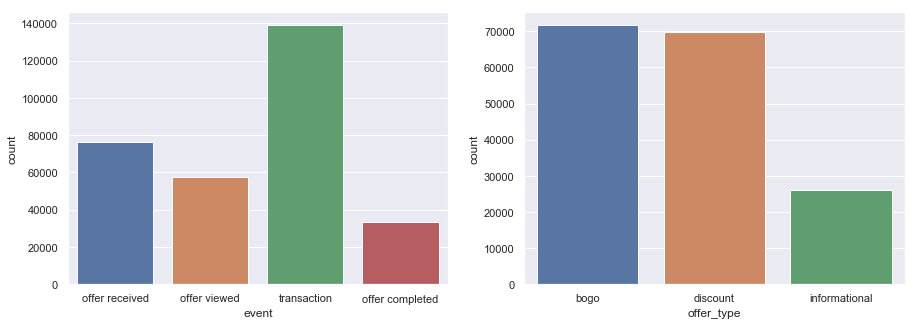

In [28]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.countplot('event', data=new_df)

plt.subplot(1,2,2)
sns.countplot('offer_type', data=new_df)

plt.show()

The distributions of different types of Starbucks offers look quite uniform.

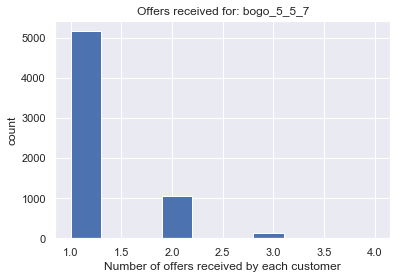

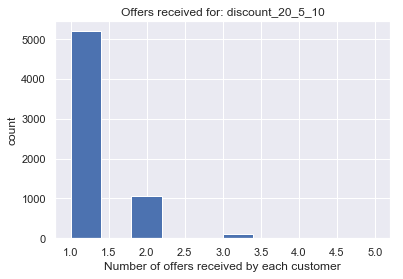

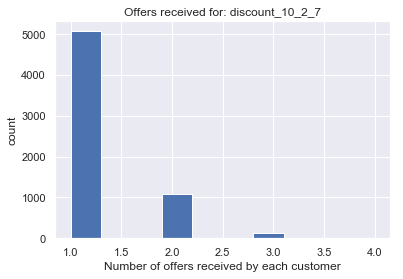

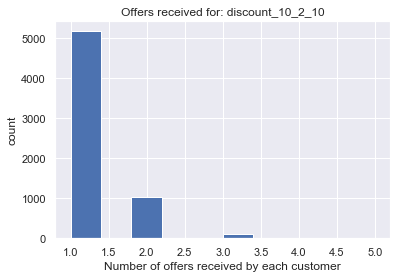

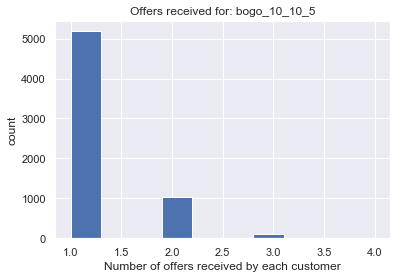

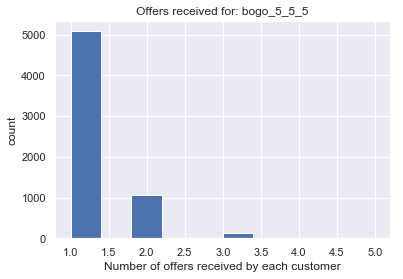

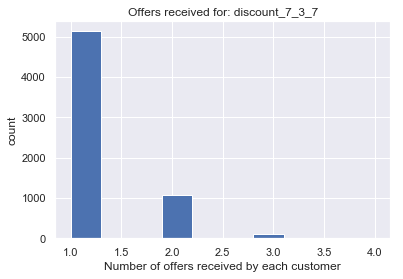

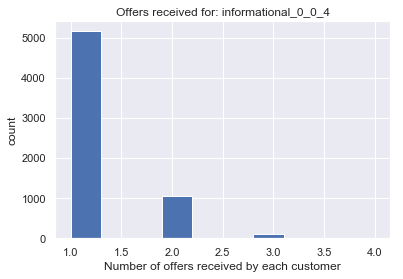

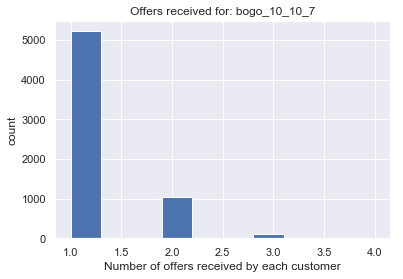

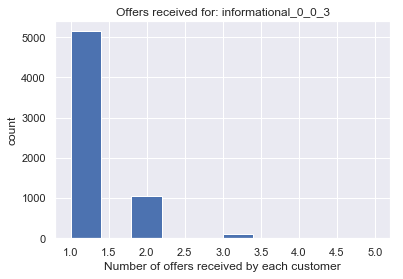

In [30]:
for offer in received.type.unique():
    received[received.type==offer]['person'].value_counts().hist()
    plt.xlabel('Number of offers received by each customer')
    plt.ylabel('count')
    plt.title('Offers received for: ' + offer)
    plt.show()

Some customers receive the same offer more than once. They could be the loyal, long-standing members? Something to keep in mind.

**Spending**

Average spending
count    16578.000000
mean        13.680266
std         16.056763
min          0.050000
25%          3.181392
50%         11.996607
75%         20.469643
max        451.470000
Name: amount, dtype: float64
-----------------
Total spending
count    17000.000000
mean       104.438351
std        125.922619
min          0.000000
25%         21.820000
50%         69.405000
75%        148.782500
max       1608.690000
Name: amount, dtype: float64
-----------------
Numbers of Transaction
count    17000.000000
mean         8.173706
std          5.116250
min          0.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         36.000000
Name: amount, dtype: float64
-----------------


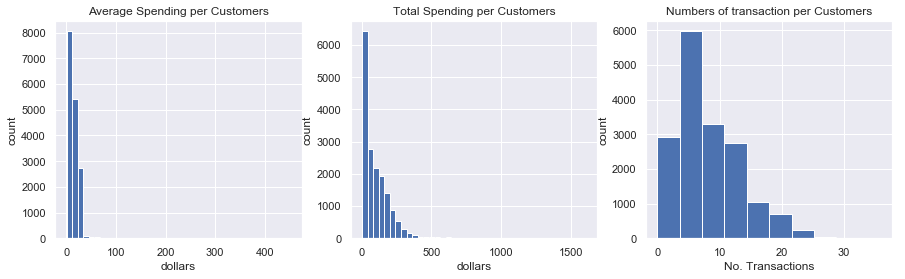

In [32]:
plt.figure(figsize=(15,4))
# let's look at the average spending of each customers
plt.subplot(131)
new_df.groupby('person')['amount'].mean().hist(bins=40)
plt.xlabel('dollars')
plt.ylabel('count')
plt.title('Average Spending per Customers')
print('Average spending')
print(new_df.groupby('person')['amount'].mean().describe())
print('-----------------')

# look at the total spending per customer
plt.subplot(132)
new_df.groupby('person')['amount'].sum().hist(bins=40)
plt.xlabel('dollars')
plt.ylabel('count')
plt.title('Total Spending per Customers')
print('Total spending')
print(new_df.groupby('person')['amount'].sum().describe())
print('-----------------')

# look at the total transaction per customer
plt.subplot(133)
new_df.groupby('person')['amount'].count().hist()
plt.xlabel('No. Transactions')
plt.ylabel('count')
plt.title('Numbers of transaction per Customers')
print('Numbers of Transaction')
print(new_df.groupby('person')['amount'].count().describe())
print('-----------------')

* Starbucks customers spend 13.6 dollars on average
* In total, on average, Starbucks customers spend 104.5 dollars, a few spends up to 1,609 dollars, and many don't buy anything at all
* On average, people make 8 transactions; however, some make up to 36 transactions over the course of 5 years

#### Genders

In [9]:
new_df.gender.value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [34]:
new_df.gender.isnull().sum()

33772

In [11]:
new_df.head(3)

,event,person,time,value,offer_id,amount,age,became_member_on,gender,income,difficulty,duration,offer_type,reward,type,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,bogo_5_5_7,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,118,2017-08-04,None,NaN,20.0,10.0,discount,5.0,discount_20_5_10,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,68,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,discount_10_2_7,1.0,1.0,0.0,1.0


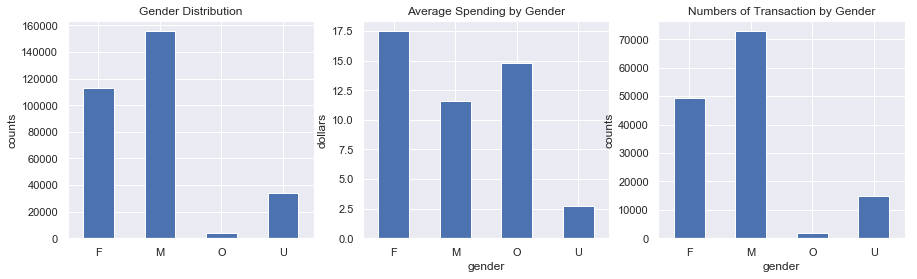

In [10]:
# let's take a look at average spending by gender
# there are 33772 missing values so we will assign these as 'U'
new_df_ = new_df.copy()
new_df_.loc[new_df.gender.isnull(), 'gender'] = 'U'

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))

# plot gender distribution
new_df_.gender.value_counts()[['F','M','O','U']].plot(kind='bar', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel('counts')
ax1.set_title('Gender Distribution')

# plot average spending
new_df_.groupby('gender')['amount'].mean()[['F','M','O','U']].plot(kind='bar', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('dollars')
ax2.set_title('Average Spending by Gender')

# plot numbers of transaction
new_df_.groupby('gender')['amount'].count()[['F','M','O','U']].plot(kind='bar', ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.set_ylabel('counts')
ax3.set_title('Numbers of Transaction by Gender')

plt.show()

* There are more male customers than females
* Female customers spend more on average than male customers
* Male customers make more purchases than female customers

**Offer Received, Offer Reviewed, and Offer Completed**

**Offer Types**
Let's take a look to see which `offer type` has more customer views and customer purchase rates:

<Figure size 1080x504 with 0 Axes>

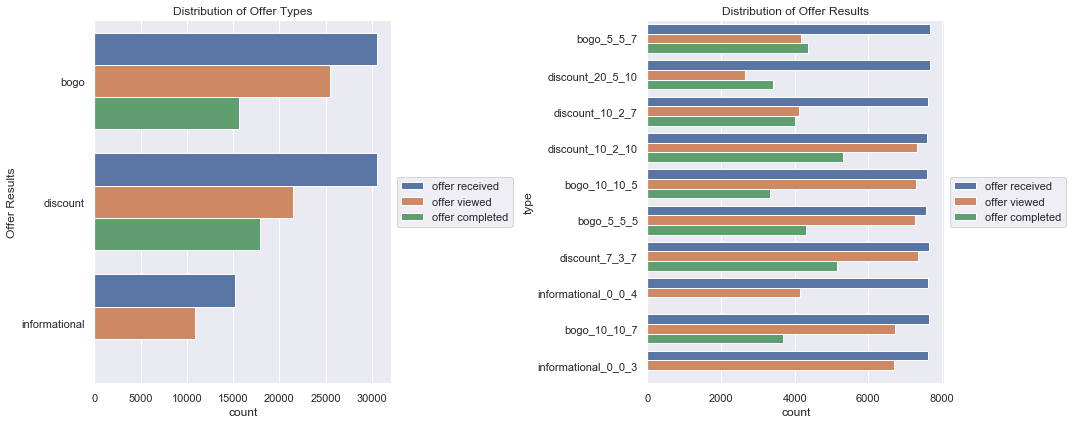

In [58]:
plt.figure(figsize=(15,7))

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

sns.countplot(y='offer_type', hue='event', data=new_df[new_df.event != 'transaction'], ax=ax1)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax1.set_ylabel('Offer Results')
ax1.set_title('Distribution of Offer Types')

sns.countplot(y='type', hue='event', data=new_df[new_df.event != 'transaction'], ax=ax2)
ax2.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax2.set_title('Distribution of Offer Results')

plt.tight_layout()
plt.show()

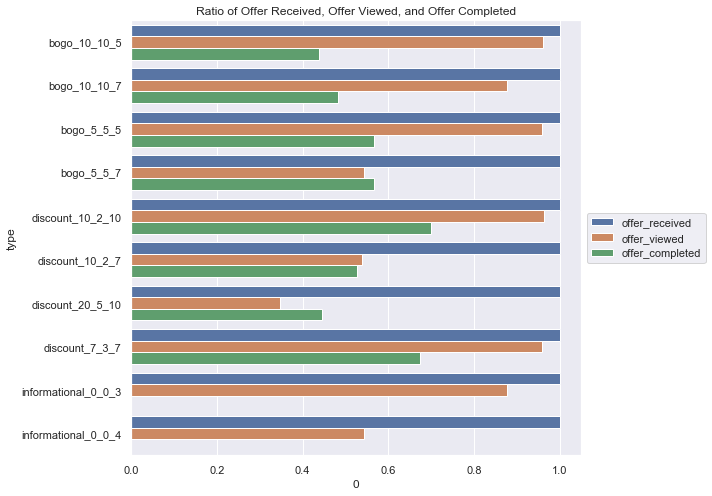

In [44]:
ratio = new_df[new_df.event != 'transaction'].groupby(['type','event']).size().unstack()

ratio['offer_received'] = ratio['offer received']/ratio['offer received']
ratio['offer_viewed'] = ratio['offer viewed']/ratio['offer received']
ratio['offer_completed'] = ratio['offer completed']/ratio['offer received']

all_ratios = ratio[['offer_received','offer_viewed','offer_completed']].stack().reset_index()

plt.figure(figsize=(10,7))
sns.barplot(x=0, y='type', hue='event', data=all_ratios)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Ratio of Offer Received, Offer Viewed, and Offer Completed')
plt.tight_layout()
plt.show()

### Overalls:

* `bogo` has more views than both `discount` and `informational` offers
* `discount` has the most completion
* `informational` has no completion
* Notice that for some of them there are more `offer_completed` than `offer_viewed`.

## Feature Processing

In [31]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 19 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
value               306534 non-null object
offer_id            167581 non-null object
amount              138953 non-null float64
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
reward              167581 non-null float64
type                167581 non-null object
email               167581 non-null float64
mobile              167581 non-null float64
social              167581 non-null float64
web                 167581 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(2), object(7

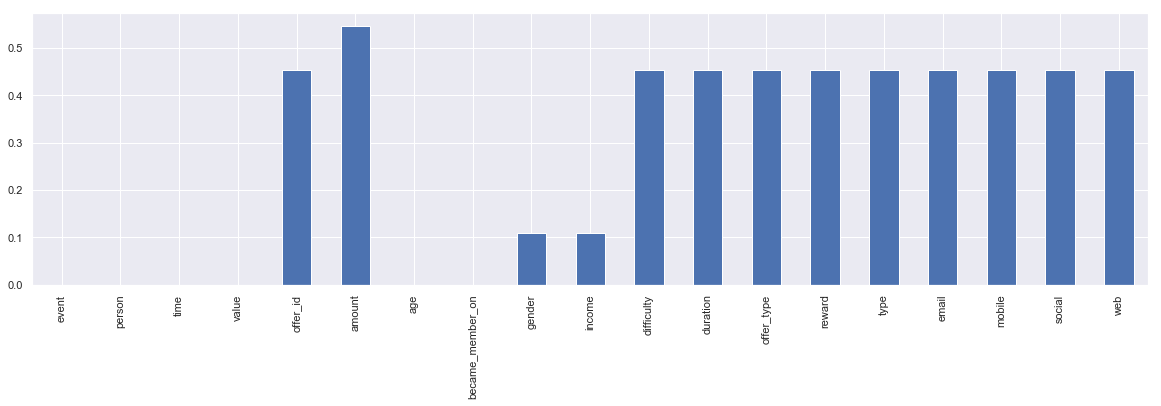

In [86]:
null_col = new_df.isnull().sum()
null_col_frac = null_col/new_df.shape[0]
plt.figure(figsize=(20,5))
null_col_frac.plot(kind='bar')

In [32]:
# separate data with age >=100 and missing value on gender and income
df = new_df[new_df.age<100]
df.isnull().sum()

event                    0
person                   0
time                     0
value                    0
offer_id            123802
amount              148628
age                      0
became_member_on         0
gender                   0
income                   0
difficulty          123802
duration            123802
offer_type          123802
reward              123802
type                123802
email               123802
mobile              123802
social              123802
web                 123802
dtype: int64

In [33]:
# drop unimportant and redundant columns
df.drop(['offer_id','value'], axis=1, inplace=True)

C:\Users\vungu\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
# get dummies for the event and type column
df = pd.get_dummies(df, columns=['event','type','offer_type'])

Since the null values associated with the original data sets are already taken care of, the new null values are associated with newly created columns due to one-hot encoding and can be safely converted to `0`. 

In [36]:
df.fillna(0, inplace=True)

In [37]:
df.isnull().sum()

person                      0
time                        0
amount                      0
age                         0
became_member_on            0
gender                      0
income                      0
difficulty                  0
duration                    0
reward                      0
email                       0
mobile                      0
social                      0
web                         0
event_offer completed       0
event_offer received        0
event_offer viewed          0
event_transaction           0
type_bogo_10_10_5           0
type_bogo_10_10_7           0
type_bogo_5_5_5             0
type_bogo_5_5_7             0
type_discount_10_2_10       0
type_discount_10_2_7        0
type_discount_20_5_10       0
type_discount_7_3_7         0
type_informational_0_0_3    0
type_informational_0_0_4    0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
dtype: int64

In [38]:
df.became_member_on.describe()

count                  272430
unique                   1707
top       2017-12-07 00:00:00
freq                      635
first     2013-07-29 00:00:00
last      2018-07-26 00:00:00
Name: became_member_on, dtype: object

In [39]:
# make new columns for became_member_on
import datetime
df.loc[:,'days'] = (datetime.datetime(2018,7,27) - df.became_member_on).dt.days
df.drop('became_member_on',axis=1,inplace=True)

In [40]:
# set person column as index
df.set_index('person', inplace=True)
df.head(3)

,time,amount,age,gender,income,difficulty,duration,reward,email,mobile,...,type_discount_10_2_10,type_discount_10_2_7,type_discount_20_5_10,type_discount_7_3_7,type_informational_0_0_3,type_informational_0_0_4,offer_type_bogo,offer_type_discount,offer_type_informational,days
person,,,,,,,,,,,,,,,,,,,,,
78afa995795e4d85b5d9ceeca43f5fef,0,0.0,75,F,100000.0,5.0,7.0,5.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,444
e2127556f4f64592b11af22de27a7932,0,0.0,68,M,70000.0,10.0,7.0,2.0,1.0,1.0,...,0,1,0,0,0,0,0,1,0,92
389bc3fa690240e798340f5a15918d5c,0,0.0,65,M,53000.0,5.0,5.0,5.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,168


**Gender**

Since there are 3 different gender types in the `gender` column, we will binary encode them, where:

 `O` = 0
 `F` = 1
 `M` = 2

In [41]:
# Binary code gender columns with O: 0, F:1, M:2
df.gender = df.gender.map({'O':0, 'F':1, 'M':2})
df.head(3)

,time,amount,age,gender,income,difficulty,duration,reward,email,mobile,...,type_discount_10_2_10,type_discount_10_2_7,type_discount_20_5_10,type_discount_7_3_7,type_informational_0_0_3,type_informational_0_0_4,offer_type_bogo,offer_type_discount,offer_type_informational,days
person,,,,,,,,,,,,,,,,,,,,,
78afa995795e4d85b5d9ceeca43f5fef,0,0.0,75,1,100000.0,5.0,7.0,5.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,444
e2127556f4f64592b11af22de27a7932,0,0.0,68,2,70000.0,10.0,7.0,2.0,1.0,1.0,...,0,1,0,0,0,0,0,1,0,92
389bc3fa690240e798340f5a15918d5c,0,0.0,65,2,53000.0,5.0,5.0,5.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,168


**Feature Correlation**

Text(0.5, 1.0, 'Features Correlation')

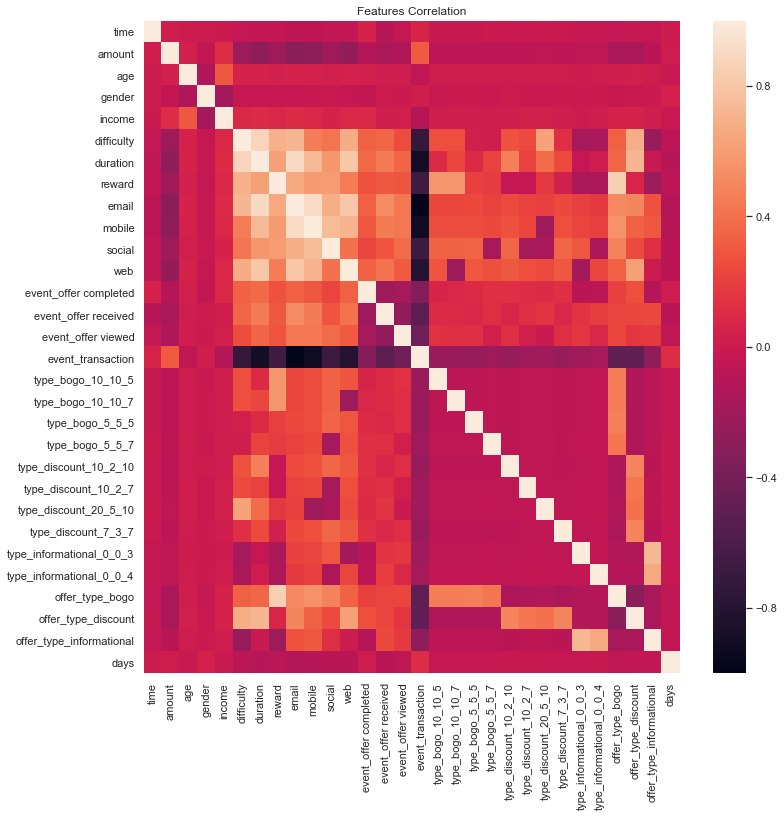

In [43]:
cols = ['time', 'amount', 'age', 'gender', 'income', 'difficulty', 'duration',
       'reward', 'email', 'mobile', 'social', 'web', 'event_offer completed',
       'event_offer received', 'event_offer viewed', 'event_transaction',
       'type_bogo_10_10_5', 'type_bogo_10_10_7', 'type_bogo_5_5_5',
       'type_bogo_5_5_7', 'type_discount_10_2_10', 'type_discount_10_2_7',
       'type_discount_20_5_10', 'type_discount_7_3_7',
       'type_informational_0_0_3', 'type_informational_0_0_4',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'days']

f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(df[cols].corr(), ax=ax)
ax.set_title("Features Correlation")

* `event_offer viewed` is positively correlated with `email`, `mobile`, `social`, and somewhat `web`. So if we want our customers to take a look at the offers, email, mobile, and social will be better medium than through website. 
* `event_offer completed` is positively correlated with `duration`, `difficulty`, `reward`, `email`, `mobile`, `web`, `event_type_bogo` and somewhat `event_type_discount`. The more time people have, the higher chances of them completing the offer. The better rewards also contributing to the chances of customers completing their offers. Morever, people seem to like discount more than bogo.
* `event_transaction` is positively correlated with `amount` and negatively correlated with `difficulty`, `duration`, `reward`, `email`, `mobile`, `social`, and `web`. The people who don't receive any offers still buy Starbucks products; moreover, they don't get entangled in the mess of finishing the offers in time to get rewards.

In [44]:
df2 = df.copy()
df2.loc[df2.event_transaction > 0,'luck'] = 'no'
df2.loc[df2.event_transaction == 0,'luck'] = 'yes'
df2.head()

,time,amount,age,gender,income,difficulty,duration,reward,email,mobile,...,type_discount_10_2_7,type_discount_20_5_10,type_discount_7_3_7,type_informational_0_0_3,type_informational_0_0_4,offer_type_bogo,offer_type_discount,offer_type_informational,days,luck
person,,,,,,,,,,,,,,,,,,,,,
78afa995795e4d85b5d9ceeca43f5fef,0,0.0,75,1,100000.0,5.0,7.0,5.0,1.0,1.0,...,0,0,0,0,0,1,0,0,444,yes
e2127556f4f64592b11af22de27a7932,0,0.0,68,2,70000.0,10.0,7.0,2.0,1.0,1.0,...,1,0,0,0,0,0,1,0,92,yes
389bc3fa690240e798340f5a15918d5c,0,0.0,65,2,53000.0,5.0,5.0,5.0,1.0,1.0,...,0,0,0,0,0,1,0,0,168,yes
2eeac8d8feae4a8cad5a6af0499a211d,0,0.0,58,2,51000.0,0.0,4.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0,1,258,yes
aa4862eba776480b8bb9c68455b8c2e1,0,0.0,61,1,57000.0,20.0,10.0,5.0,1.0,0.0,...,0,1,0,0,0,0,1,0,319,yes


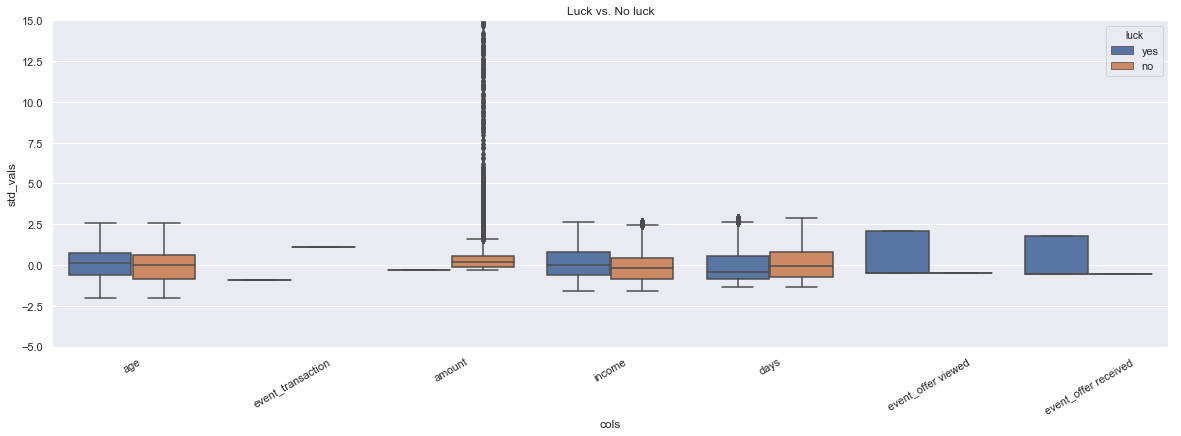

In [45]:
cols = ['age', 'event_transaction', 'amount','income', 'days', 'event_offer viewed', 'event_offer received']
main = df2.copy()
main_std = (df2[cols] - df2[cols].mean()) / df2[cols].std()
#main_std = main_std.drop('no', axis=1)
main_std['luck'] = main['luck']

main_melt = main_std.melt(['luck'], var_name='cols',  value_name='std_vals')


f, ax = plt.subplots(figsize=(20,6))
sns.boxplot('cols','std_vals', hue='luck', data=main_melt, ax=ax, hue_order=['yes','no'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);
ax.set_ylim(-5,15);
ax.set_title("Luck vs. No luck");

* There are more people who receive offers than those who don't. However, people who don't receive offers also make more purchase.

* People who don't receive offers also tend to be slightly younger, are earlier member, have lower income, and lower offer view times. 

### Feature Transformation- Standardization

In [46]:
from sklearn.preprocessing import StandardScaler

def scaling(df):
    scaler = StandardScaler()
    ss = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(ss, index=df.index, columns=df.columns)
    return df_scaled, scaler

df_s, scaler = scaling(df)

C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\vungu\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [47]:
df_s.head()

,time,amount,age,gender,income,difficulty,duration,reward,email,mobile,...,type_discount_10_2_10,type_discount_10_2_7,type_discount_20_5_10,type_discount_7_3_7,type_informational_0_0_3,type_informational_0_0_4,offer_type_bogo,offer_type_discount,offer_type_informational,days
person,,,,,,,,,,,,,,,,,,,,,
78afa995795e4d85b5d9ceeca43f5fef,-1.83029,-0.282321,1.213249,-1.060299,1.679661,0.128453,0.926147,0.773283,0.912669,0.999288,...,-0.26618,-0.232524,-0.217597,-0.265285,-0.219331,-0.196509,1.808924,-0.544089,-0.301008,-0.322657
e2127556f4f64592b11af22de27a7932,-1.83029,-0.282321,0.812948,0.843911,0.267170,1.052130,0.926147,-0.127239,0.912669,0.999288,...,-0.26618,4.300639,-0.217597,-0.265285,-0.219331,-0.196509,-0.552815,1.837934,-0.301008,-1.143402
389bc3fa690240e798340f5a15918d5c,-1.83029,-0.282321,0.641391,0.843911,-0.533241,0.128453,0.379040,0.773283,0.912669,0.999288,...,-0.26618,-0.232524,-0.217597,-0.265285,-0.219331,-0.196509,1.808924,-0.544089,-0.301008,-0.966196
2eeac8d8feae4a8cad5a6af0499a211d,-1.83029,-0.282321,0.241090,0.843911,-0.627407,-0.795223,0.105487,-0.727587,0.912669,0.999288,...,-0.26618,-0.232524,-0.217597,-0.265285,-0.219331,5.088815,-0.552815,-0.544089,3.322175,-0.756346
aa4862eba776480b8bb9c68455b8c2e1,-1.83029,-0.282321,0.412648,-1.060299,-0.344909,2.899482,1.746806,0.773283,0.912669,-1.000712,...,-0.26618,-0.232524,4.595651,-0.265285,-0.219331,-0.196509,-0.552815,1.837934,-0.301008,-0.614114


# Machine Learning- Unsupervised

## Affinity Propagation

Affinity Propagation takes as input measures of similarity between pairs of data points, and simultaneously considers all data points as potential exemplars. Affinity Propagation doesn't require pre-selected number of clusters and is not affected by centroid initialization.

In [106]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# make sure the number of rows divides evenly into 4 samples
rows = df_s.shape[0] - df_s.shape[0]%4
X = df_s.iloc[:rows, :]

# dataframe to store features and predicted cluster memberships
ypred = pd.DataFrame()

# create the 2-feature PCA for graphing purposes
Xpca = PCA(2).fit_transform(X)

# split data into 4 equally sized samples
Xhalf1, Xhalf2, Xpca_h1, Xpca_h2 = train_test_split(X, Xpca, test_size=0.5, random_state=1)

X1, X2, Xpca1, Xpca2 = train_test_split(Xhalf1, Xpca_h1, test_size=0.5, random_state=1)
X3, X4, Xpca3, Xpca4 = train_test_split(Xhalf2, Xpca_h2, test_size=0.5, random_state=1)

In [107]:
from sklearn.cluster import AffinityPropagation

ypred_ap = pd.DataFrame()
score_ap = pd.DataFrame(columns=['clusters_pred', 'silhouette_score'])

for counter, data in enumerate([X1,X2,X3,X4]):
    data = data[:7912][:]
    af = AffinityPropagation().fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    labels = af.labels_
    s_score = metrics.silhouette_score(data, labels, metric='euclidean')
    score_ap = score_ap.append({'clusters_pred' : 'clust' + str(n_clusters_) + '_sample' + str(counter),
                                'silhouette_score' : s_score}, ignore_index=True)
    
score_ap.sort_values(by='silhouette_score', ascending=False)

,clusters_pred,silhouette_score
1,clust153_sample1,0.19
3,clust150_sample3,0.19
0,clust152_sample0,0.19
2,clust155_sample2,0.19


* The results don't look good as in both the numbers of clusters and the silhouette scores.

## Mean Shift Model

Mean-shift assigns the data points to the clusters iteratively by shifting points towards the mode (mode is the highest density of data points in the region). Mean Shift doesn’t assume any prior shape like spherical, elliptical, etc. on data clusters and does not require specifying the number of clusters in advance. The number of clusters is determined by the algorithm with respect to the data. 

In [108]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# initialize dataframe
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['clusters_pred', 'quantile'])

# keep track of counts of the model and use data from the different folds
for counter, data in enumerate([X1,X2,X3,X4]):
    # quantile list
    for n in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        # estimate the number of clusters
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=1000)
        # ensuring all sets are same length
        data = data[:7912][:]
        # instantiate and fit predict model before adding to df
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        centers = len(np.unique(labels))
        ypred_ms['clust' + str(centers) + '_sample' + str(counter)] = pred
        # calc silhoutte scores 
        s_scores = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms = score_ms.append({'clusters_pred' : 'clust'+ str(centers) + '_sample' + str(counter),
                                    'silhouette_score' : s_scores,
                                    'quantile' : n,
                                    }, ignore_index=True)
        
score_ms.sort_values(by='silhouette_score', ascending=False)

,clusters_pred,quantile,silhouette_score
17,clust2_sample2,0.6,0.79
23,clust2_sample3,0.6,0.75
22,clust2_sample3,0.5,0.75
16,clust3_sample2,0.5,0.72
4,clust2_sample0,0.5,0.67
5,clust2_sample0,0.6,0.67
11,clust3_sample1,0.6,0.62
10,clust4_sample1,0.5,0.62
1,clust12_sample0,0.2,0.54
0,clust12_sample0,0.1,0.54


* Output depends on window size, which I am not confident in determining.
* Window size (bandwidth) selection is not trivial.
* Computationally (relatively) expensive.
* Hard to choose the optimal number of clusters based on the results.
* Doesn’t scale well with dimension of feature space.


## Mini-Batch K-Means

Mini-Batch K-Means works similarly to the k-means algorithm. In mini-batch k-means the most computationally costly step is conducted on only a random sample of observations as opposed to all observations. Since I have a big dataset and the previous modeling methods took a significant amount of run time, let's see if this approach can reduce the time required for the algorithm to find convergence (i.e. fit the data) with only a small cost in quality. 

In [109]:
from sklearn.cluster import MiniBatchKMeans

# initialize dataframe
ypred_mb = pd.DataFrame()
score_mb = pd.DataFrame(columns=['clusters_pred', 'silhouette_score'])

# Each batch will be made up of 1000 data points.
for counter, data in enumerate([X1,X2,X3,X4]):
    for i in range(7,13):
        minibatchkmeans = MiniBatchKMeans(
                        init='random',
                        n_clusters=i, 
                        random_state=1)
        pred = minibatchkmeans.fit_predict(data)
        labels = minibatchkmeans.labels_
        centers = len(np.unique(labels))
        ypred_mb['clust' + str(centers) + '_sample' + str(counter)] = pred
        # calc silhouette socres
        s_scores = metrics.silhouette_score(data, labels, metric='euclidean')
        score_mb = score_mb.append({'clusters_pred' : 'clust'+ str(centers) + '_sample' + str(counter),
                                    'silhouette_score' : s_scores}, ignore_index=True)
        
        
score_mb.sort_values(by='silhouette_score', ascending=False)

,clusters_pred,silhouette_score
13,clust8_sample2,0.42
21,clust10_sample3,0.26
9,clust10_sample1,0.26
22,clust11_sample3,0.25
23,clust12_sample3,0.25
19,clust8_sample3,0.24
15,clust10_sample2,0.24
16,clust11_sample2,0.23
11,clust12_sample1,0.23
17,clust12_sample2,0.23


Silhouette scores don't look too good and ain't reproducible across 4 different folds for each clusters.

Let's move on to K-Means.

## K-Means 

### Determining the Optimal Number of Clusters:

Let's employ the Silhouette coefficient, Inertia (SSE) and the Elbow method to determine the best number of clusters:

In [88]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

def finding_num_cluster(X, min_clusters =2, max_clusters =30):
    silh = []
    inertia = []
    clusters = range(min_clusters,max_clusters)
    for n in tqdm(clusters):

        model = KMeans(n_clusters = n, random_state=42)
        preds = model.fit_predict(X)

        silhouette_avg = silhouette_score(X, preds)

        silh.append(silhouette_avg)
        inertia.append(model.inertia_)

    fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
    ax1.plot(clusters, silh,marker="o")
    ax1.set_ylabel("Silhoutte Score")
    ax1.set_xlabel('number of clusters')
    ax2.plot(clusters, inertia, marker="x")
    ax2.set_ylabel("Inertia (SSE)")
    ax2.set_xlabel("number of clusters")
    plt.show()

100%|██████████| 28/28 [6:13:11<00:00, 810.05s/it]  


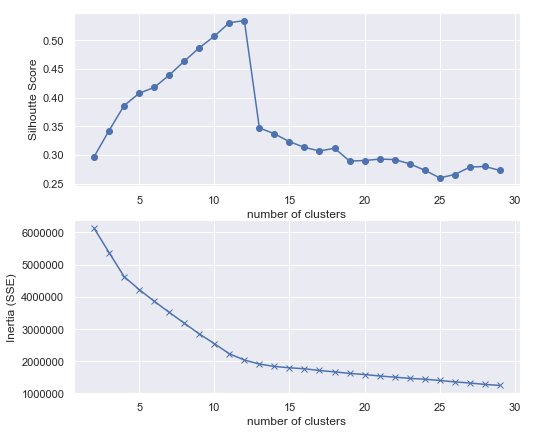

In [89]:
# define_num(df_pca)
finding_num_cluster(df_s)

Taken both silhouette score and SSE into consideration, clusters of 10, 11, or 12 look like a good condidate for the optimum cluster. However, let's try a few other methods, like the elbow method, visualization, and consistency of silhouette against 4 different folds to determine our chosen number of clusters. 

In [49]:
# find the appropriate cluster number
from sklearn.cluster import KMeans
wcss = []
for i in range(1,31):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(df_s)
    wcss.append(kmeans.inertia_)

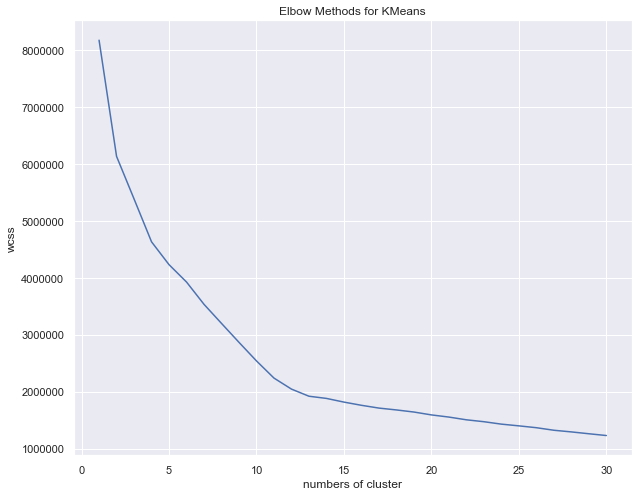

In [51]:
plt.figure(figsize=(10,8))
plt.plot(range(1,31),wcss)
plt.title('Elbow Methods for KMeans')
plt.xlabel('numbers of cluster')
plt.ylabel('wcss')
plt.show()

**10 clusters** looks most desirable as the wcss score decreases slowly from 10 to 11 to 12 clusters. 

In [52]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# make sure the number of rows divides evenly into 4 samples
rows = df_s.shape[0] - df_s.shape[0]%4
X = df_s.iloc[:rows, :]

# dataframe to store features and predicted cluster memberships
ypred = pd.DataFrame()

# create the 2-feature PCA for graphing purposes
Xpca = PCA(2).fit_transform(X)

# split data into 4 equally sized samples
Xhalf1, Xhalf2, Xpca_h1, Xpca_h2 = train_test_split(X, Xpca, test_size=0.5, random_state=1)

X1, X2, Xpca1, Xpca2 = train_test_split(Xhalf1, Xpca_h1, test_size=0.5, random_state=1)
X3, X4, Xpca3, Xpca4 = train_test_split(Xhalf2, Xpca_h2, test_size=0.5, random_state=1)

In [90]:
for counter, data in enumerate([(X1, Xpca1),
                                (X2, Xpca2),
                                (X3, Xpca3),
                                (X4, Xpca4)]):
    # put the features into ypred
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:,0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:,1]

    # generate cluster predictions and store them for clusters 7 to 13
    for nclust in range(8,14):
        pred = KMeans(n_clusters=nclust, random_state=1).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

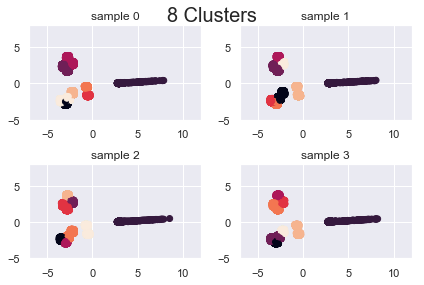

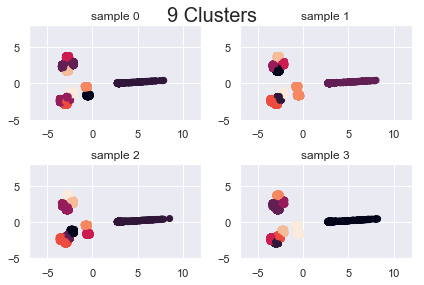

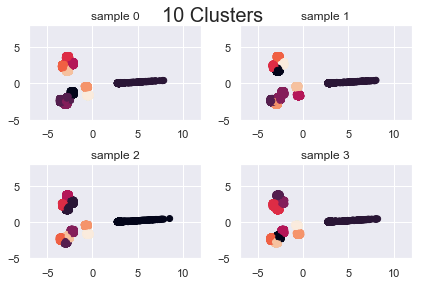

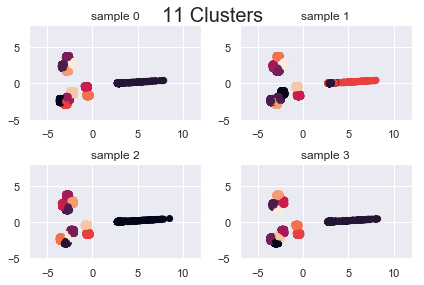

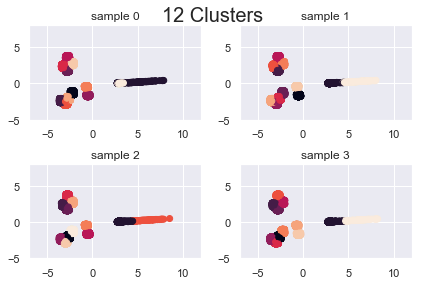

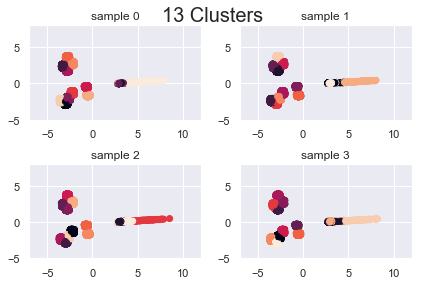

In [91]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(8, 14):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-7, 12])
        axarr[rows, cols].set_ylim([-5, 8])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Personally, I find visualization method is the least useful in determining the optimal number of clusters. Nevertheless, **10 clusters** or less look much better to me than 11 or 12 clusters in this case. 

In [92]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

for i in range(8,14):
    for sample in [X1, X2, X3, X4]:
        model = KMeans(n_clusters=i, random_state=1).fit(sample)
        labels = model.labels_
        s_scores = metrics.silhouette_score(sample, labels, metric='euclidean')
        print('Clusters = {}'.format(i))
        print(s_scores)

Clusters = 8
0.46615539444643894
Clusters = 8
0.4620462803069362
Clusters = 8
0.46114352874215536
Clusters = 8
0.46352301701396365
Clusters = 9
0.4812615399902501
Clusters = 9
0.48104909434792054
Clusters = 9
0.48412667968876005
Clusters = 9
0.48708226322236026
Clusters = 10
0.5076593494415371
Clusters = 10
0.5051279188009202
Clusters = 10
0.5041425920294718
Clusters = 10
0.5099281934071513
Clusters = 11
0.5309017697445442
Clusters = 11
0.3157376630984632
Clusters = 11
0.5301527871259082
Clusters = 11
0.5299726198674222
Clusters = 12
0.3384153635128082
Clusters = 12
0.5340469980229002
Clusters = 12
0.5337158209028421
Clusters = 12
0.5337524085827043
Clusters = 13
0.3335879753353921
Clusters = 13
0.3388286548612632
Clusters = 13
0.3392193768697646
Clusters = 13
0.32058611426354927


11 and 12 clusters have higher silhouette scores than 10 clusters, however, their scores are also the least consistent across 4 folds compared to 10 clusters. Overall, taken into account the high silhouette score and consitency, **10** is the optimal number of clusters for our dataset.

## Chosen Model: 10-clusters K-Means

In [57]:
km_k10 = KMeans(n_clusters=10, random_state=1).fit(df)
labels_k10 = km_k10.labels_
silh_k10 = metrics.silhouette_score(df, labels_k10, metric='euclidean')
print('Silhouette score of k=10:')
print(silh_k10)

pred_k10 = km_k10.predict(df)

cluster_df = df.copy()
cluster_df['cluster_assigned'] = pred_k10

clusters_df = {}
for nclusters in range(10):
    clusters_df[nclusters] = cluster_df.loc[cluster_df['cluster_assigned']==nclusters]

for name, frame in clusters_df.items():
    print('Feature: {}'.format(name))
    print('\n')
    print(frame.describe())

Silhouette score of k=10:
0.5302246185430571
Feature: 0


               time        amount           age        gender        income  \
count  30031.000000  30031.000000  30031.000000  30031.000000  30031.000000   
mean     368.489028      3.179696     48.204156      1.653125  33722.320269   
std      200.733697     10.219312     18.537697      0.513605   2158.577040   
min        0.000000      0.000000     18.000000      0.000000  30000.000000   
25%      192.000000      0.000000     33.000000      1.000000  32000.000000   
50%      408.000000      0.440000     47.000000      2.000000  34000.000000   
75%      534.000000      4.535000     62.000000      2.000000  36000.000000   
max      714.000000    377.190000     98.000000      2.000000  37000.000000   

         difficulty      duration        reward         email        mobile  \
count  30031.000000  30031.000000  30031.000000  30031.000000  30031.000000   
mean       3.649762      3.129566      2.094436      0.474376      0.439

               time        amount           age        gender        income  \
count  32219.000000  32219.000000  32219.000000  32219.000000  32219.000000   
mean     367.775847      3.609609     47.575902      1.684503  41912.629194   
std      201.110977     12.906883     18.628778      0.484407   2592.763745   
min        0.000000      0.000000     18.000000      0.000000  38000.000000   
25%      186.000000      0.000000     32.000000      1.000000  40000.000000   
50%      408.000000      0.450000     47.000000      2.000000  42000.000000   
75%      534.000000      4.770000     62.000000      2.000000  44000.000000   
max      714.000000    454.620000     97.000000      2.000000  46000.000000   

         difficulty     duration        reward         email        mobile  \
count  32219.000000  32219.00000  32219.000000  32219.000000  32219.000000   
mean       3.685000      3.13551      2.089016      0.476893      0.441789   
std        5.151682      3.60662      3.200506      0.

               time        amount           age        gender        income  \
count  26701.000000  26701.000000  26701.000000  26701.000000  26701.000000   
mean     366.275046      5.948065     52.102955      1.603798  65543.462792   
std      200.755830     18.521901     17.595354      0.520140   1670.439304   
min        0.000000      0.000000     18.000000      0.000000  63000.000000   
25%      186.000000      0.000000     39.000000      1.000000  64000.000000   
50%      408.000000      0.000000     52.000000      2.000000  66000.000000   
75%      528.000000     10.170000     64.000000      2.000000  67000.000000   
max      714.000000    639.590000     98.000000      2.000000  68000.000000   

         difficulty      duration        reward         email        mobile  \
count  26701.000000  26701.000000  26701.000000  26701.000000  26701.000000   
mean       4.132018      3.508932      2.302648      0.529194      0.485675   
std        5.366080      3.658939      3.260037    

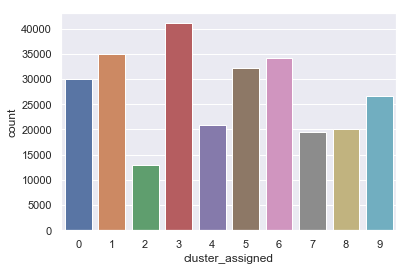

In [58]:
sns.countplot(cluster_df['cluster_assigned'])
plt.show()

* Majority of the data is in cluster 0, 1, 3, 5, and 6.

In [80]:
def inverse_transform_centroid(df,kmeans):
    centers = kmeans.cluster_centers_
    centers = pd.DataFrame(centers, columns=df.columns)
    return centers

df_k10centroid = inverse_transform_centroid(df, km_k10)

# standardize centroid value
df_k10centroid_std = (df_k10centroid - df_k10centroid.mean())/df_k10centroid.std()

def compare_features(df, features, xlabel = 'cluster', ylabel = 'std value', figsize = (10,8)):
    """ This function is just to plot selected features"""
    n_cols = len(features)
    rows = n_cols//2 + (n_cols % 2 >0)
    
    f, axs = plt.subplots(rows,2, figsize=figsize)
    axs = axs.flatten()

    for i in range(n_cols):
        sns.barplot(df.index,features[i], data= df, ax= axs[i])
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(ylabel)
        axs[i].set_title('Feature : ' + features[i])
        
    plt.tight_layout()


In [86]:
df_k10centroid

,time,amount,age,gender,income,difficulty,duration,reward,email,mobile,social,web,event_offer completed,event_offer received,event_offer viewed,event_transaction,type_bogo_10_10_5,type_bogo_10_10_7,type_bogo_5_5_5,type_bogo_5_5_7,type_discount_10_2_10,type_discount_10_2_7,type_discount_20_5_10,type_discount_7_3_7,type_informational_0_0_3,type_informational_0_0_4,offer_type_bogo,offer_type_discount,offer_type_informational,days
0,368.49,3.18,48.20,1.65,33722.32,3.65,3.13,2.09,0.47,0.44,0.32,0.38,0.08,0.23,0.16,0.53,0.05,0.05,0.05,0.05,0.06,0.04,0.03,0.06,0.04,0.03,0.21,0.19,0.08,565.30
1,365.51,7.04,53.89,1.55,72053.35,4.40,3.67,2.50,0.55,0.51,0.36,0.45,0.13,0.24,0.18,0.45,0.07,0.06,0.06,0.05,0.06,0.05,0.05,0.07,0.04,0.04,0.24,0.23,0.08,567.60
2,364.86,11.48,64.88,1.33,111983.82,5.08,4.20,2.87,0.63,0.58,0.42,0.51,0.17,0.28,0.18,0.37,0.07,0.07,0.08,0.06,0.08,0.06,0.05,0.07,0.05,0.04,0.28,0.27,0.09,543.76
3,365.76,4.60,50.53,1.63,51369.59,4.04,3.41,2.28,0.52,0.47,0.34,0.41,0.10,0.24,0.18,0.48,0.05,0.06,0.06,0.05,0.06,0.05,0.04,0.06,0.05,0.03,0.22,0.21,0.08,592.68
4,368.51,9.90,61.61,1.42,87805.53,5.11,4.24,2.84,0.63,0.57,0.40,0.51,0.16,0.26,0.21,0.37,0.06,0.07,0.07,0.07,0.07,0.06,0.06,0.07,0.05,0.04,0.28,0.27,0.09,573.09
5,367.78,3.61,47.58,1.68,41912.63,3.68,3.14,2.09,0.48,0.44,0.33,0.38,0.08,0.23,0.16,0.52,0.05,0.05,0.06,0.04,0.06,0.04,0.04,0.06,0.05,0.03,0.20,0.20,0.08,595.23
6,367.90,5.31,51.48,1.58,58892.32,4.12,3.50,2.33,0.53,0.49,0.35,0.43,0.11,0.24,0.19,0.47,0.06,0.06,0.06,0.05,0.06,0.05,0.04,0.07,0.05,0.04,0.23,0.22,0.08,604.82
7,365.14,11.05,61.92,1.40,97460.86,5.02,4.15,2.85,0.63,0.57,0.41,0.51,0.16,0.26,0.20,0.37,0.07,0.07,0.07,0.06,0.07,0.06,0.06,0.07,0.05,0.04,0.27,0.26,0.09,585.98
8,365.62,8.71,61.50,1.42,79351.86,5.14,4.24,2.79,0.63,0.57,0.40,0.52,0.16,0.26,0.21,0.37,0.07,0.07,0.07,0.06,0.08,0.06,0.06,0.07,0.05,0.04,0.26,0.28,0.09,579.04
9,366.28,5.95,52.10,1.60,65543.46,4.13,3.51,2.30,0.53,0.49,0.34,0.43,0.11,0.23,0.18,0.47,0.05,0.06,0.06,0.05,0.07,0.05,0.04,0.06,0.04,0.04,0.22,0.22,0.08,586.79


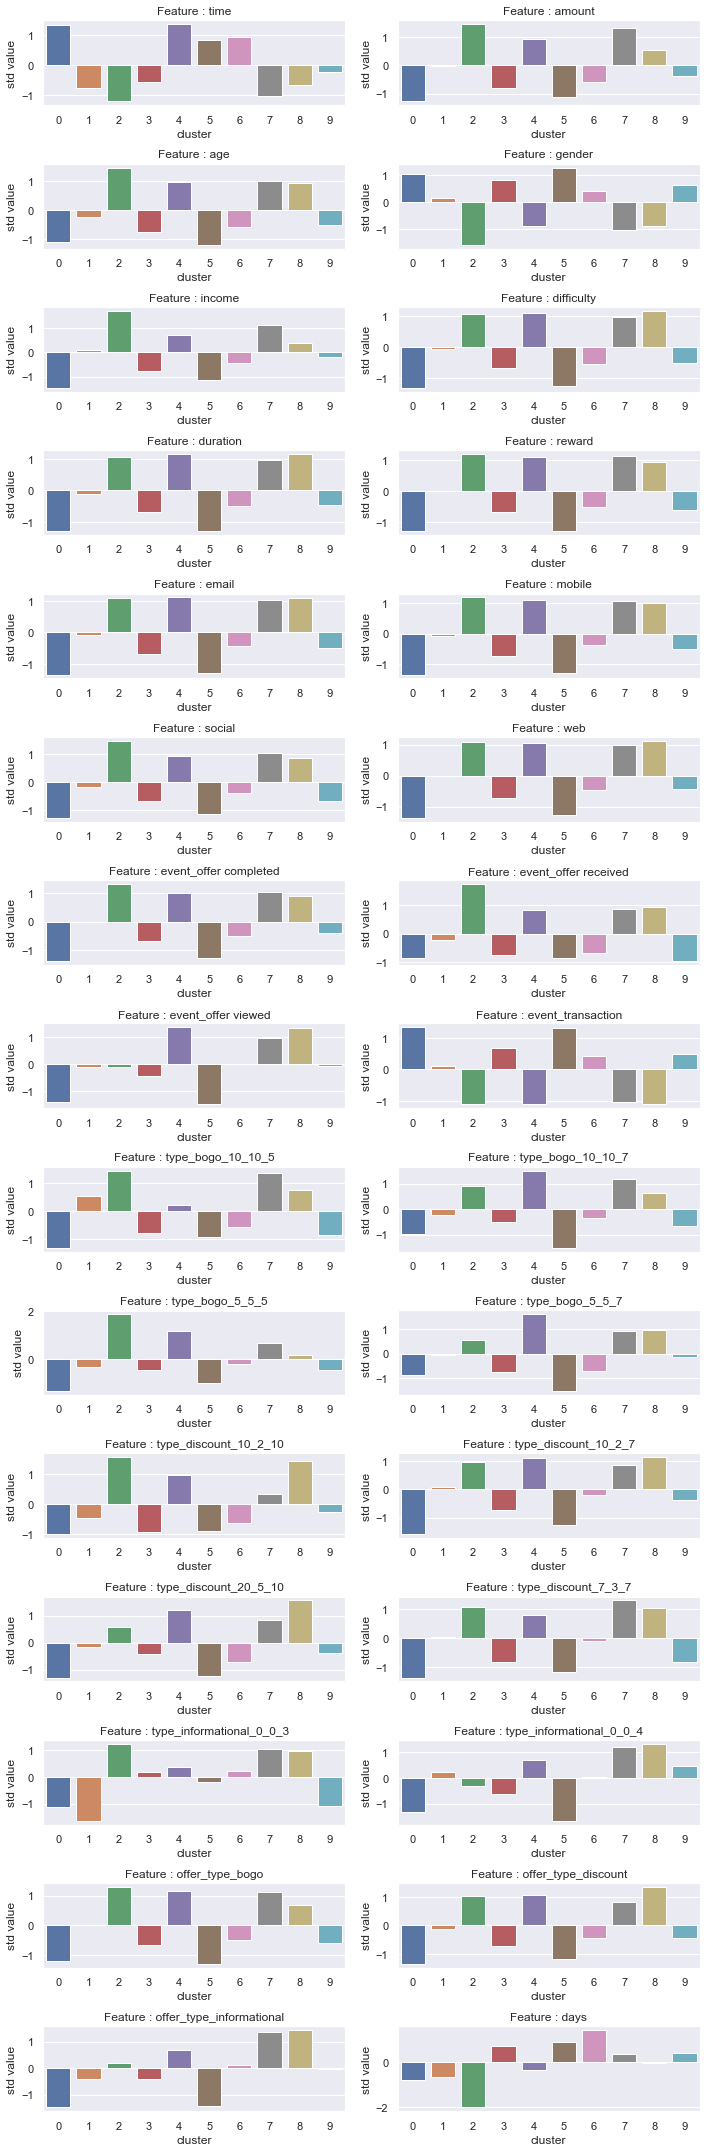

In [82]:
features = ['time', 'amount', 'age', 'gender', 'income', 'difficulty', 'duration',
            'reward', 'email', 'mobile', 'social', 'web', 'event_offer completed',
            'event_offer received', 'event_offer viewed', 'event_transaction',
            'type_bogo_10_10_5', 'type_bogo_10_10_7', 'type_bogo_5_5_5',
            'type_bogo_5_5_7', 'type_discount_10_2_10', 'type_discount_10_2_7',
            'type_discount_20_5_10', 'type_discount_7_3_7',
            'type_informational_0_0_3', 'type_informational_0_0_4',
            'offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 'days']

compare_features(df_k10centroid_std, features, figsize=(10,30))

## Discussions

### Responsive Clusters:

* Resonsive to BOGO (all 4 types): Clusters 2, 4, 7, 8 
* Responsive to Discounts (all 4 types): Clusters 2, 4, 7, 8
* Reponsive to Information (either types): Majority in clusters 7 and 8, some in 4 and very few in 2 and 6. 
* No-Offer Customers: 0,1(barely),3,5,6,9 (majority 0 and 5)
* Offer complete: Clusters 2,4,7,8

### Characteristics of Clusters: 

**BOGO, Discount, and Information**

* Cluster 2: ave. age of 65 (std 11), ave. income of 111984 (std 4444), being a member for about 568 days or 1.6 years (+/- 301, so more than half a year to about 2 years), more responsive to email (63%) than other media, least responsive to social (42%). spent 11.5 dollars on average.

* Clusters 4: ave. age of 62 (std 13), ave. income of 87806 (std 2564), being a member for about 573 days 1.6 years (+/- 301, so more than half a year to about 2 years), more responsive to email (63%) than other media, least responsive to social (40%), spent 9.90 dollars on average. 

* Clusters 7: ave. age of 62 (std 13), ave. income of 97461 (std 3161), being a member for about 586 days or 1.6 years (+/- 301, so more than half a year to about 2 years), spent 11.05 dollars on average, more responsive to email (63%) than other media, least responsive to social (41%)

* Clusters 8: ave. age of 62 (std 13), ave. income of 79352 (std 2236), being a member for about 579 days or 1.6 years (+/- 301, so more than half a year to about 2 years), spent 8.71 dollars on average, more responsive to email (63%) than other media, least responsive to social (40%) 

* People in the highest income bracket (above 100k) are more responsive to BOGO, whereas those in the upper midle bracker (above 70k) are more responsive to discount and dnformational offers.

* People in the highest income bracket (above 100k, cluster 2) are least responive to informational offer.

* Overall, those who responsive to any types of offer are older (average age of 62), have decent income (72k or more), and generally check emails more. 

**No-Offer/Regular Purchases Customers**

* Clusters 0: ave. age of 48 (std 13), ave. income of 33722 (std 3161),  being a member for about 565 days or 1.5 years (+/- 301, so more than half a year to about 2 years), spent 3.18 dollars on average, less responsive to email (47%), mobile (44%), social (32%) and web (38%) in general.

* Clusters 5: ave. age of 48 (std 13), ave. income of 41913 (std 2236), being a member for about 595 days or 1.6 years (+/- 301, so more than half a year to about 2 years), spent 3.65 dollars on average, less responsive to email (48%), mobile (44%), social (33%) and web (38%) in general.

* Clusters 6: ave. age of 51 (std 13), ave. income of 58892 (std 3161),  being a member for about 605 days or 1.6 years (+/- 301, so more than half a year to about 2 years), spent 5.31 dollars on average, slightly more responsive to email (53%) and mobile (49%) than social (35%) and web (43%) in general.

* Clusters 9: ave. age of 52 (std 13), ave. income of 65543 (std 2236), being a member for about 587 days or 1.6 years (+/- 301, so more than half a year to about 2 years), spent 8.71 dollars on average, slightly more responsive to email (53%) and mobile (49%) than social (34%) and web (43%) in general.

* Regular customers (or those who make purchases without receiving any kinds of offer) tend to be younger (average age of 48), have less income, and generally ain't responsive to any kind of advertisement media. 

* These customers also tend to spend less money (less than 9 dollars/purchase) than Offer-Received customers (more than 8 dollars/purchase).

**Other Features:**

* Cluster 2: among the oldest, with highest income bracket and highest spending rate.
* Cluster 0: opposite of cluster 2.

**Modelings**: 

* MiniBatch K-Means might have cut down run time (but not by much on my dataset) and is supposed to work similarly to the k-means algorithm; however, I receive relatively worse results as in cluster numbers and silhouette scores across various folds.

* Mean-Shift and Affinity Propagation both give bad silhouette scores and confusing looking cluster numbers. Even though there is an initial advantage of not choosing the cluster number nor centroid itialization values, these algorithms are not appropriate for my dataset. 

* While developing models, I find K-Means to be the most suitable algorithm, in term of both run time and silhouette scores. 

* However, a big constraint of K-Means is that it does not yield the same result with each run since the resulting clusters depend on the initial random assigments. One way to address this problem is by re-running k-Means algorithm several times, each with different random initializations of the centroids. Another possible method is to use a different clustering technique, such as hierarchical clustering and use the resultant cluster centroids as my initial k-Means centroid; however, I am short on both time and computer power to address the centroid initialization issue. 

* Another inherent limitation from k-means is that it assumes the variance of the distribution of each attribute is spherical and all attributes have the same variance. There are other factors that I didn't use in this modeling process and they might have some influences on the variance.


## Shortcomings & Future Direction

* Instead of binary encoding, I should have one-hot encoded the `gender` variable so that each gender type has its own column and from there I can access the gender types that associated with each cluster and find out which one is more responsive to offers. 

* For the No-Offer groups, I should also take a look into their membership timelime to separate the loyal, regular customers from the curious, one-time buyer group. 

* There are other feature combinations (for example, offer completion or offer incompletion based on different discount types, offer completion or offer incompletion based on different reward types) that I didn't think of until the very end of my analyses. Since the whole modeling process takes a significant amount of time, I can't just randomly add features then redo the run all over again. 

* The above feature additions will help guiding business perspective and decision more, for example, if a customer is going to make a purchase despite not receiving a discount anyway, then we don't have to offer them anthing. Knowing that customer and the demographic group she/he belongs to will be very valuable. 

* If I can maximize the avaiable data by coming up with more unique feature engineers, the more information I can gain about the customer demographics and patterns. 